# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 3 # Options are [1, 2, 3, 4]
test_type = 'attack_type' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Show the first five lines of the dataframe to see if everything was read accordingly 




### Basic dataset label arrangements

In [2]:
# Fill the blank attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)
df.head()
column_list=df.columns.to_list()


In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
def  notn(d):
    for column in d.columns[d.isna().any()].tolist():
        # d.drop(column, axis=1, inplace=True)
        d[column] = d[column].fillna('None')
        d[column] = d[column].replace('""','None')
    d['request.body'] = d['request.body'].replace('','None')


    return d
    # If you want to detect columns that may have only some NaN values use this:
    # df.loc[:, df.isna().any()].tolist()
df=notn(df)

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,None,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,None,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,None,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,None,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,Benign,Benign
5,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=D1BjJ_30Rg5rKZH7SVbAg12ryUdQo0DSW0Ybbd6u9...,"Thu, 15 Dec 2022 00:42:10 GMT",GET,http://127.0.0.1:5000/orders/get/random/7,None,200 OK,application/json,23,200,"[{}, {}, {}, {}, {}, {}, {}]",None,None,None,None,Benign,Benign
6,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; rv:36.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=bzUzzBklbXuRAzVP3Xl_xfnQmx8wBLeG7eZmqXyVz...,"Thu, 15 Dec 2022 00:02:48 GMT",GET,http://127.0.0.1:5000/orders/get/random/2,None,200 OK,application/json,8,200,"[{}, {}]",None,None,None,None,Benign,Benign
7,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=8-7fMclcho3wDJWYkTv-xcN_nkutBJIpfAwTc0Dm4...,"Thu, 15 Dec 2022 00:48:23 GMT",GET,http://127.0.0.1:5000/about/greet?id=2504858.3...,None,200 OK,text/html; charset=utf-8,3719,200,text/html; charset=utf-8,None,None,None,None,Benign,Benign
8,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=t3B4Z4uGbRWIUOJFvgQzcgwWnjNy_ySPIiIqsdw2Z...,"Thu, 15 Dec 2022 00:43:28 GMT",GET,http://127.0.0.1:5000/states/get/region/north,None,200 OK,application/json,338,200,"[{""state_abbr"": ""AK"", ""state_name"": ""Alaska"", ...",None,None,None,None,Benign,Benign
9,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=rTNSLoSeCsY_zGUc9tSbu31sjlcQuudgrn5yBycIQ...,"Thu, 15 Dec 2022 00:41:15 GMT",GET,http://127.0.0.1:5000/categories/check/name/Me..

In [4]:
#This function add all the new features we've create to maximize our model
def addfunc(df):
    #create list of words that identify the RCE attack
    selected_words=["__.__","(os)","alert"]
    #create new colum for marking the raws that contion one or more of the selected words above
    df["countRCE"]= 0
    for i in selected_words:
        df['countRCE'] =df['countRCE']+ list(map(lambda x: x.count(i), df['request.url']))
    #lambda function to create new feature for identify cookie injection attack
    df["cook"]=df["request.url"].apply(lambda x : 1 if 'http://127.0.0.1:5000/cookielogin' in x else 0)
    #create new DataFrame for idwntify the log4j attack
    LOGdf=pd.DataFrame()
    #create colums acording to excist featurs
    LOGdf['encoding']=df['request.headers.Accept-Encoding']
    LOGdf['site']=df['request.headers.Sec-Fetch-Site']
    LOGdf['dest']=df['request.headers.Sec-Fetch-Dest']
    #lambda functions for adding numbers to the colums we've created according to their values
    LOGdf['encoding'] =LOGdf['encoding'].apply(lambda x: 0 if  x == 'gzip, deflate, br' else 1)
    LOGdf['site'] =LOGdf['site'].apply(lambda x: 0 if  x == 'none' else 1)
    LOGdf['dest'] =LOGdf['dest'].apply(lambda x: 0 if  x == 'document' else 1)
    #create new colum that sum the colums above for checking if any of them has valuse of 1
    LOGdf['count'] =LOGdf['dest']+LOGdf['site']+LOGdf['encoding']
    #filling NaN with 0
    LOGdf['count'] = LOGdf['count'].fillna(0)
    #replacing any x>1 with 1
    LOGdf["count"]=LOGdf['count'].apply(lambda x: 1 if  x > 0 else 0)
    df["LogAn"]=LOGdf['count']
    #create 2 featurs that calculate the len of their headers 
    df["request.url_len"]=df["request.url"].str.len()
    df["resBodLen"]=df["response.body"].str.len()
    #completing featur for detact the log4j attack 
    df["jndi"]=df["request.headers.Set-Cookie"].apply(lambda x: 1 if "${jndi:" in x else 0)
    #create list of words that identify the SQL injection attack
    selected_words=["SELECT","FROM","limit"]
    #create new colum for marking the raws that contion one or more of the selected words above
    df["countSQL"]= 0
    for i in selected_words:
        df['countSQL'] =df['countSQL']+ list(map(lambda x: x.count(i), df['request.url']))
    #lambda function to create new feature for identify Log Forging attack  
    df["LogF"]=df["request.url"].apply(lambda x: 1 if "http://127.0.0.1:5000/orders/check/exists?val=" in x else 0)

In [5]:
# On these headers we will run LevelEncoder
SIMPLE_HEADERS = [
                'request.headers.Accept-Language',
                'response.headers.Content-Type',
                'request.headers.Content-Length',
                'request.headers.Sec-Fetch-Mode',
#                 'request.headers.Sec-Ch-Ua-Mobile',
#                 'request.headers.Cache-Control',
#                 'request.headers.Sec-Ch-Ua-Platform',
#                 'request.headers.Upgrade-Insecure-Requests'
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = [
                    'response.body',
                    'request.url',
                    'response.status',
                    ]

COLUMNS_TO_REMOVE = ['request.headers.Date',
                     'response.status_code',
                     'request.body',
                     'response.headers.Set-Cookie',
                     'request.headers.Set-Cookie',
                     'response.headers.Content-Length',
                     'request.headers.Sec-Fetch-Dest', 
                     'request.headers.Accept-Encoding',
                     'request.headers.Sec-Fetch-Site',
                     'request.headers.Host',
                     'request.method',
                     'request.headers.User-Agent',
                     'response.headers.Location',
                     'request.headers.Cookie',
                     'request.headers.Accept',
                     'request.headers.Connection',
                     'request.headers.Sec-Fetch-User',
                    ]



# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    #add the features with function below
    addfunc(df)
    #define the LabelEncoder and HashingVectorizer
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)
    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()
    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

#call function above
df = vectorize_df(df)
df.head()


,request.headers.Accept-Language,request.headers.Sec-Fetch-Mode,request.url,response.status,response.headers.Content-Type,response.body,request.headers.Content-Length,attack_type,label,countRCE,cook,LogAn,request.url_len,resBodLen,jndi,countSQL,LogF
0,2,1,0.927173,0.707107,1,-1.000000,14,RCE,Malware,2,0,0,109,24,0,0,0
1,3,1,0.707107,0.707107,1,-1.000000,14,Benign,Benign,0,0,0,127,24,0,0,0
2,4,2,0.707107,0.707107,0,0.377964,14,Benign,Benign,0,0,0,104,88,0,0,0
3,4,2,0.000000,0.707107,0,-0.255551,14,Benign,Benign,0,0,0,111,933,0,0,0
4,1,2,0.316228,1.000000,0,0.000000,14,Benign,Benign,0,0,0,61,31,0,0,0


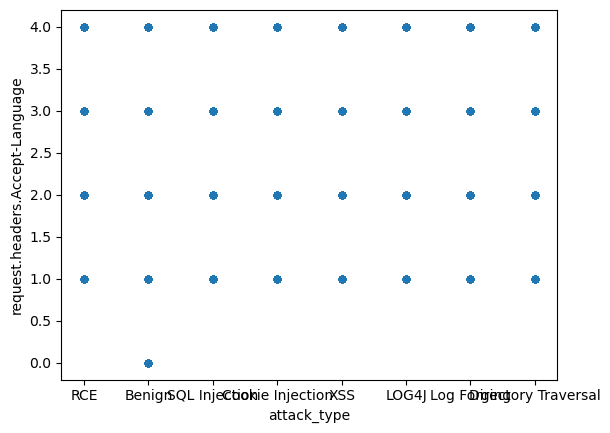

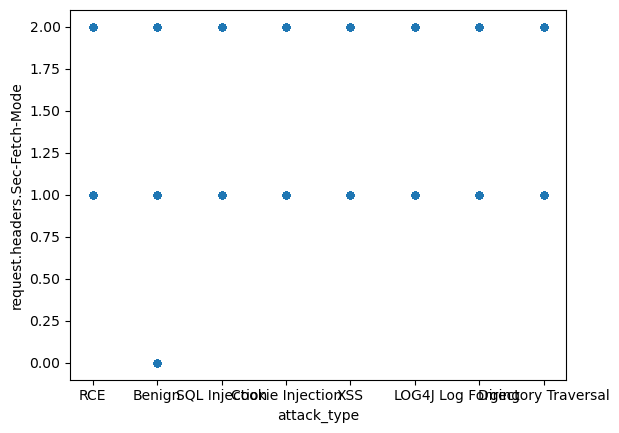

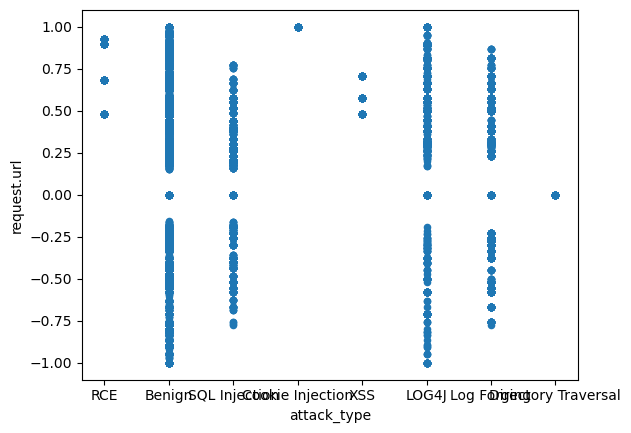

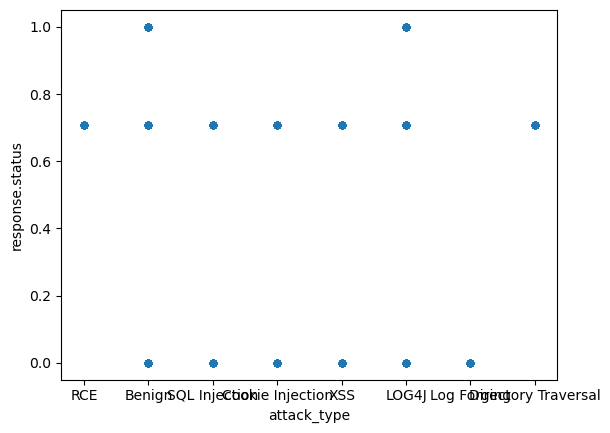

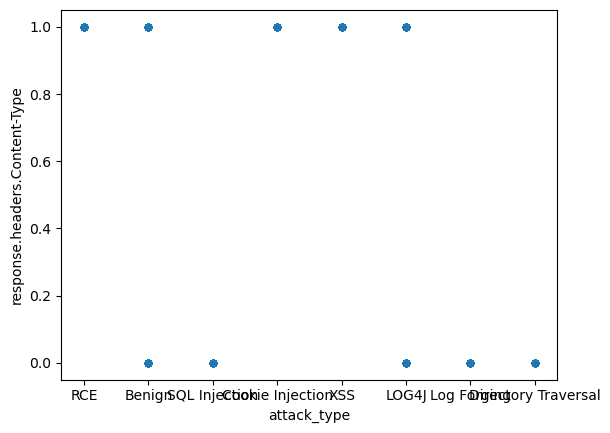

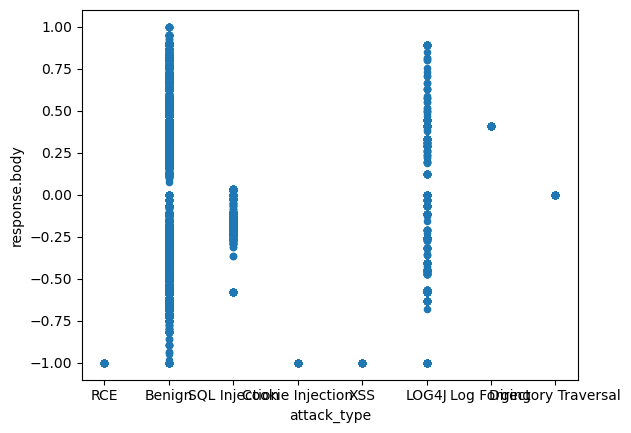

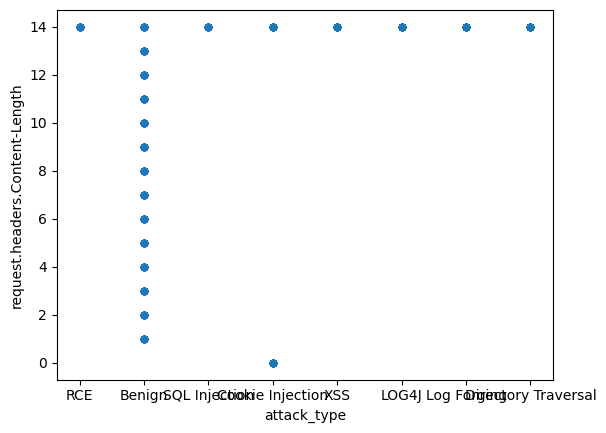

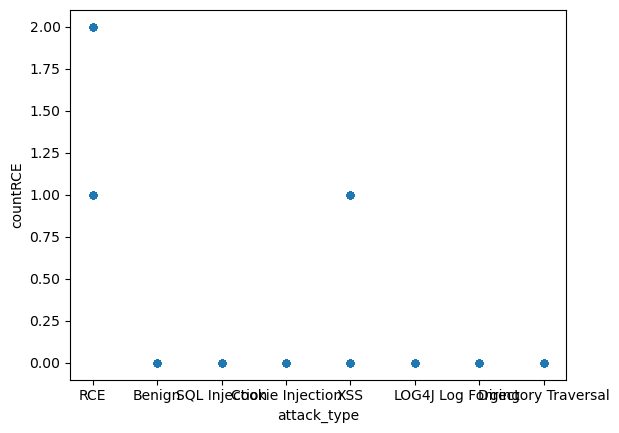

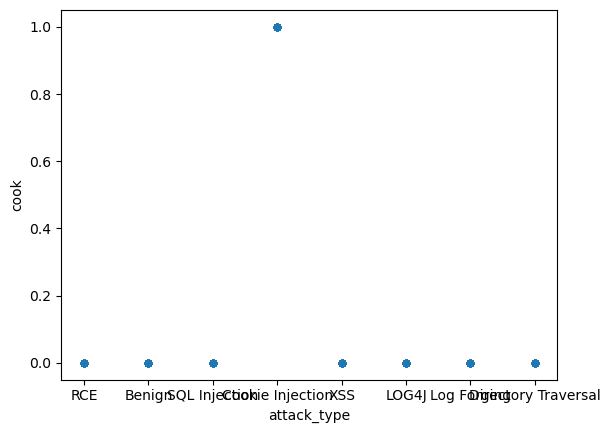

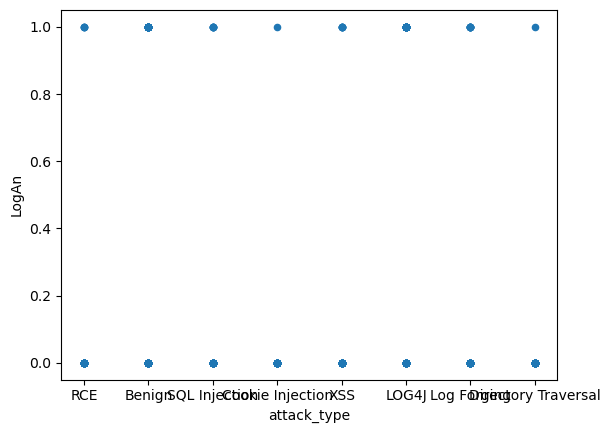

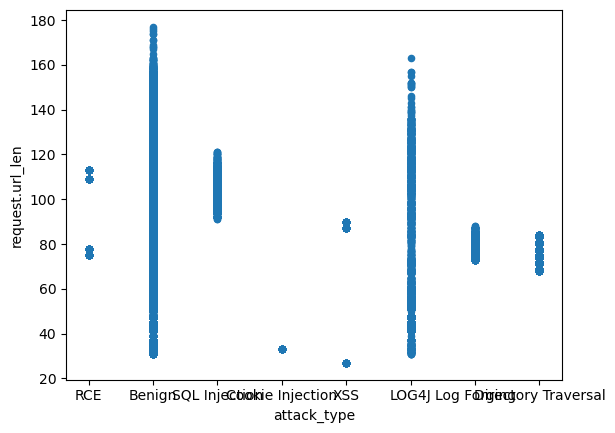

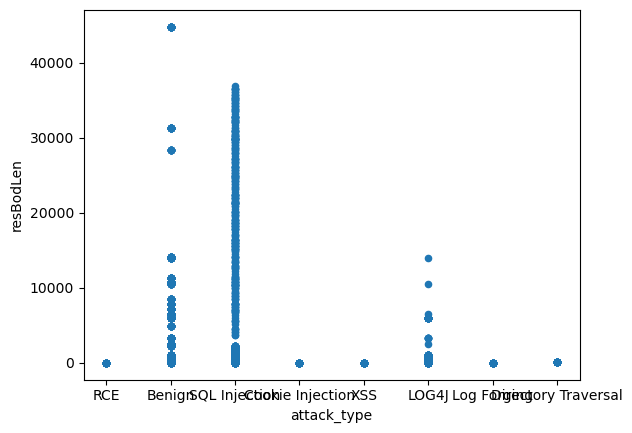

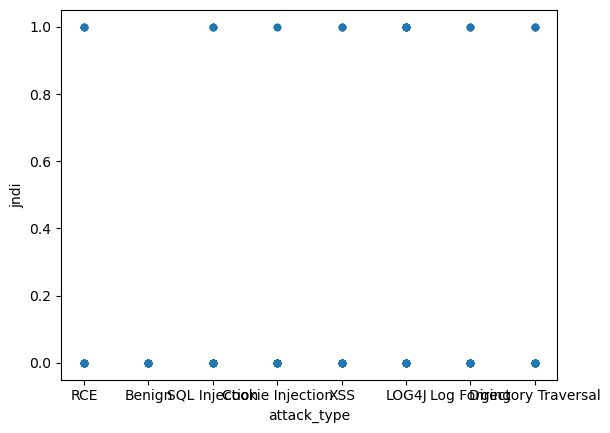

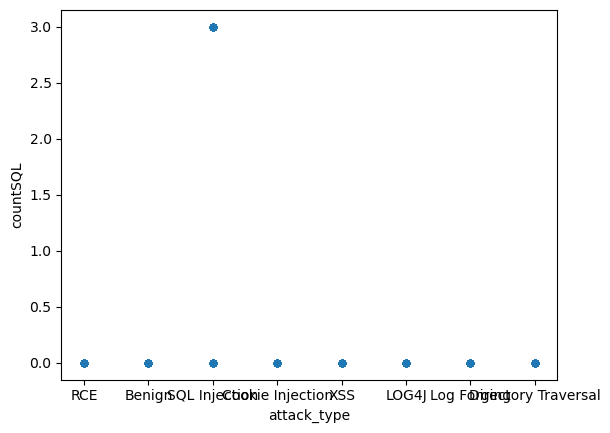

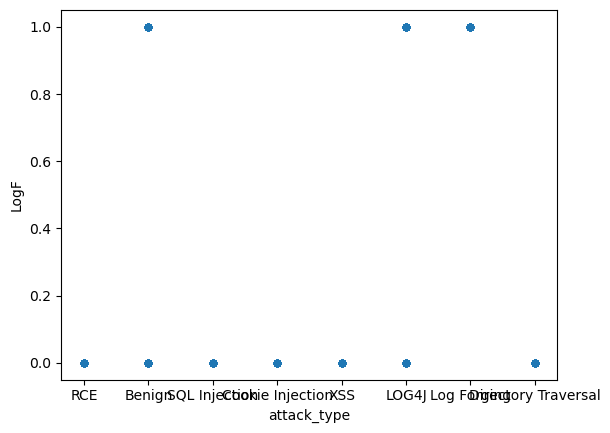

In [6]:
z
for i in df_col:
    if i!= "attack_type" and i!="label" and i!="incoockie":
        var = 'attack_type'
        data = pd.concat([df[i], df[var]], axis=1)
        data.plot.scatter(x=var, y=i );

In [7]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144500 entries, 0 to 144499
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Accept-Language  144500 non-null  int32  
 1   request.headers.Sec-Fetch-Mode   144500 non-null  int32  
 2   request.url                      144500 non-null  float64
 3   response.status                  144500 non-null  float64
 4   response.headers.Content-Type    144500 non-null  int32  
 5   response.body                    144500 non-null  float64
 6   request.headers.Content-Length   144500 non-null  int32  
 7   attack_type                      144500 non-null  object 
 8   label                            144500 non-null  object 
 9   countRCE                         144500 non-null  int64  
 10  cook                             144500 non-null  int64  
 11  LogAn                            144500 non-null  int64  
 12  re

In [8]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.
features_list = df.columns.to_list()

#remove the defintions features before the test
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Accept-Language', 'request.headers.Sec-Fetch-Mode', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.body', 'request.headers.Content-Length', 'countRCE', 'cook', 'LogAn', 'request.url_len', 'resBodLen', 'jndi', 'countSQL', 'LogF']


request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Mode       int32
request.url                        float64
response.status                    float64
response.headers.Content-Type        int32
response.body                      float64
request.headers.Content-Length       int32
attack_type                         object
label                               object
countRCE                             int64
cook                                 int64
LogAn                                int64
request.url_len                      int64
resBodLen                            int64
jndi                                 int64
countSQL                             int64
LogF                                 int64
dtype: object

## Train test split

In [9]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)
# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter


(118995, 15) (118995,)
(25505, 15) (25505,)


Counter({'RCE': 1612,
         'Benign': 128420,
         'SQL Injection': 3173,
         'Cookie Injection': 3257,
         'XSS': 3290,
         'LOG4J': 1578,
         'Log Forging': 1626,
         'Directory Traversal': 1544})

## Model choosing and fitting

In [15]:
from sklearn.ensemble import AdaBoostClassifier

# We choose our model of choice and set it's hyper parameters you can change anything
clf =RandomForestClassifier(n_estimators=50, random_state=5)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 105753), ('Cookie Injection', 2682), ('Directory Traversal', 1272), ('LOG4J', 1300), ('Log Forging', 1339), ('RCE', 1327), ('SQL Injection', 2613), ('XSS', 2709)]


## Result printout

                     precision    recall  f1-score   support

             Benign  0.9999117426 0.9996470640 0.9997793858     22667
   Cookie Injection  1.0000000000 1.0000000000 1.0000000000       575
Directory Traversal  0.9855072464 1.0000000000 0.9927007299       272
              LOG4J  1.0000000000 1.0000000000 1.0000000000       278
        Log Forging  0.9861591696 0.9930313589 0.9895833333       287
                RCE  1.0000000000 1.0000000000 1.0000000000       285
      SQL Injection  1.0000000000 1.0000000000 1.0000000000       560
                XSS  1.0000000000 1.0000000000 1.0000000000       581

           accuracy                      0.9996079200     25505
          macro avg  0.9964472698 0.9990848029 0.9977579311     25505
       weighted avg  0.9996112575 0.9996079200 0.9996088749     25505



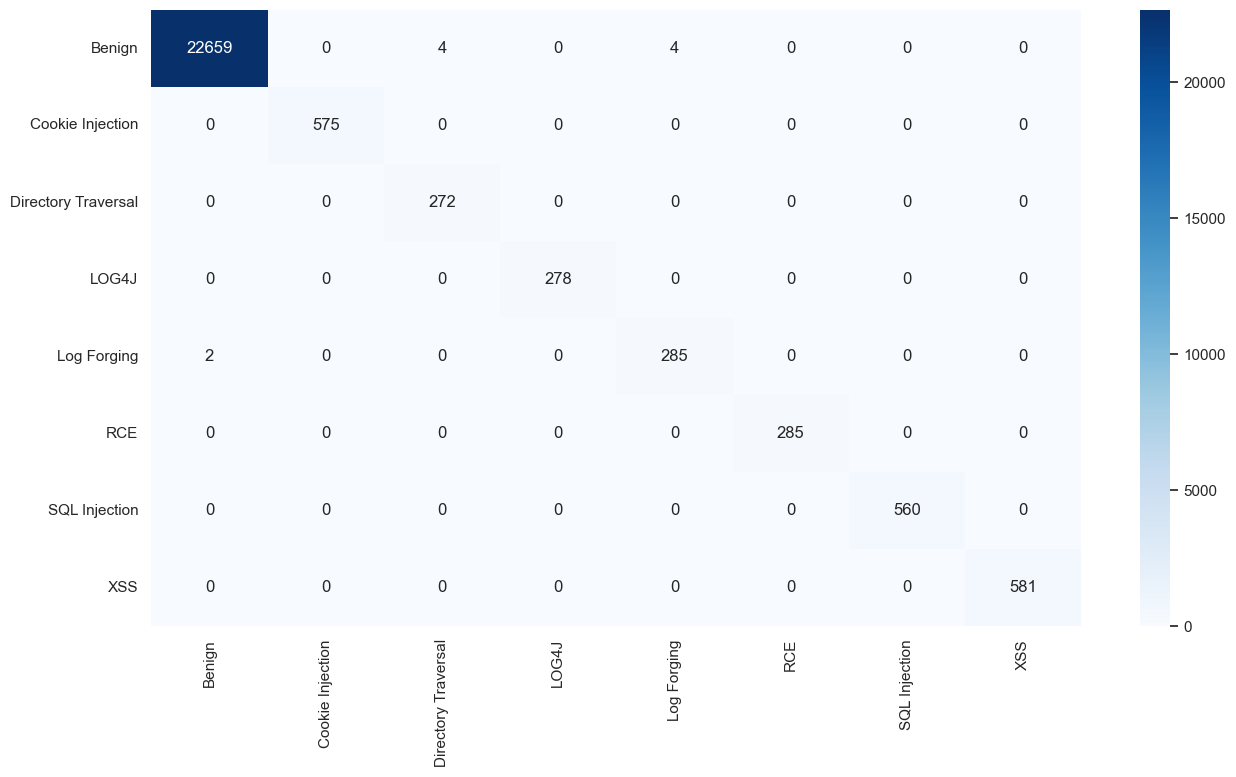

In [16]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
#Creation of the confusion matrix
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=10)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [12]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)
test_df=notn(test_df)
addfunc(test_df)
# Preprocess the validation dataset, remember that here you don't have the labels
test_df = vectorize_df(test_df)
# features_list = test_df.columns.to_list()
# Predict with your model
X = test_df[features_list].to_numpy()
# print(X)
predictions = clf.predict(X)
predictions[predictions == "Benign"] = 0
predictions[predictions =="Cookie Injection" ] = 1
predictions[predictions == "Directory Traversal"] = 2
predictions[predictions == "LOG4J"] = 3
predictions[predictions == "Log Forging"] = 4
predictions[predictions == "RCE"] = 5
predictions[predictions == "SQL Injection"] = 6
predictions[predictions == "XSS"] = 7

In [13]:
unique, counts = np.unique(predictions, return_counts=True)

dict(zip(unique, counts))


{'0': 22619,
 '1': 576,
 '2': 299,
 '3': 285,
 '4': 280,
 '5': 266,
 '6': 564,
 '7': 611}

# Save your predictions

In [14]:
# Save your preditions
enc = LabelEncoder()
print(list(enc.fit_transform(predictions)))
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')

[0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 7, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 7, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 3, 0, 0, 0, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 5, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 7, 5, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 